In [ ]:
import csv
import codecs
import argparse
import os
from pathlib import Path
import pandas as pd
import sys, argparse
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import gc
from spacy.lang.en import English
from nltk.stem.porter import *
import re
import string
from tqdm import tqdm
import numpy as np
from scipy.sparse import coo_matrix, vstack
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup

In [ ]:
path = '/content/drive/MyDrive/DATA641 Final Project/nlp_project_data/umd_reddit_suicidewatch_dataset_v2/'

# **Functions**

In [ ]:
def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens    

def ngrams(tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

In [ ]:
def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,1)):
    training_vectorizer = CountVectorizer(stop_words=stopwords_arg,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

def convert_lines_to_feature_strings(lines, stopwords, remove_stopword_bigrams=True):

    print(" Converting from raw text to unigram and bigram features")
    if remove_stopword_bigrams:
        print(" Includes filtering stopword bigrams")
        
    print(" Initializing")
    stemmer = PorterStemmer()
    nlp          = English(parser=False)
    all_features = []
    print(" Iterating through documents extracting unigram and bigram features")
    for line in tqdm(lines):
        
        # Get spacy tokenization and normalize the tokens
        spacy_analysis    = nlp(line)
        spacy_tokens      = [token.orth_ for token in spacy_analysis]
        spacy_tokens      = [stemmer.stem(token) for token in spacy_tokens]
        normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect string bigram tokens as features
        bigrams = []
        bigram_tokens     = ["_".join(bigram) for bigram in bigrams]
        bigrams           = ngrams(normalized_tokens, 2) 
        bigrams           = filter_punctuation_bigrams(bigrams)
        if remove_stopword_bigrams:
            bigrams = filter_stopword_bigrams(bigrams, stopwords)
        bigram_tokens = ["_".join(bigram) for bigram in bigrams]

        # Conjoin the feature lists and turn into a space-separated string of features.
        # E.g. if unigrams is ['coffee', 'cup'] and bigrams is ['coffee_cup', 'white_house']
        # then feature_string should be 'coffee cup coffee_cup white_house'

        bigram_tokens = " ".join(bigram_tokens)
        feature_string = bigram_tokens 

        # Add this feature string to the output
        all_features.append(feature_string)


    print(" Feature string for first document: '{}'".format(all_features[0]))
        
    return all_features

def most_informative_features(vectorizer, classifier, n=20):
    # Adapted from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#11116960
    feature_names       = vectorizer.get_feature_names()
    coefs_with_features = sorted(zip(classifier.coef_[0], feature_names))
    top                 = zip(coefs_with_features[:n], coefs_with_features[:-(n + 1):-1])
    for (coef_1, feature_1), (coef_2, feature_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, feature_1, coef_2, feature_2))

In [ ]:
def load_stopwords(filename):
    stopwords = []
    with codecs.open(filename, 'r', encoding='ascii', errors='ignore') as fp:
        stopwords = fp.read().split('\n')
    return set(stopwords)

stopwords = load_stopwords(path+'mallet_en_stoplist.txt')   

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]/,.!?]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# **Loading Data**

In [ ]:
crowd_train = pd.read_csv(path+'crowd/train/crowd_train.csv')
task_A_train = pd.read_csv(path+'crowd/train/task_A_train.posts.csv')
task_B_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
task_C_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
shared_task_train = pd.read_csv(path+'crowd/train/shared_task_posts.csv')

In [ ]:
crowd_test = pd.read_csv(path+'crowd/test/crowd_test.csv')
task_A_test = pd.read_csv(path+'crowd/test/task_A_test.posts.csv')
task_B_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
task_C_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
shared_task_test = pd.read_csv(path+'crowd/test/shared_task_posts_test.csv')

In [ ]:
label = np.array(['a','b','c','d'])
c = np.array(['Negative','Negative','Negative','Positive'])

d = np.vstack([label,c])

df_class = pd.DataFrame(data=d.T,columns=['label','class'])

df_class

,label,class
0,a,Negative
1,b,Negative
2,c,Negative
3,d,Positive


# **Task - only Suicide Watch**

In [ ]:
df_A_train = shared_task_train[shared_task_train['subreddit'] == 'SuicideWatch']
df_A_train = df_A_train.dropna()

In [ ]:
df_A_train = pd.merge(df_A_train,crowd_train,on='user_id')

df_A_train = pd.merge(df_A_train,df_class,on='label')

In [ ]:
df_A_test = shared_task_test[shared_task_test['subreddit'] == 'SuicideWatch']
df_A_test = df_A_test.dropna()

df_A_test = pd.merge(df_A_test,crowd_test,on='user_id')

df_A_test['label'] = df_A_test['raw_label']

df_A_test = pd.merge(df_A_test,df_class,on='label')

In [ ]:
X_train = convert_lines_to_feature_strings(df_A_train['post_body'],stopwords)

In [ ]:
X_train, training_vectorizer = convert_text_into_features(X_train,stopwords)

In [ ]:
X_test = convert_lines_to_feature_strings(df_A_test['post_body'],stopwords)
X_test = training_vectorizer.transform(X_test)

In [ ]:
data_A = pd.concat([df_A_train,df_A_test],axis=0)

In [ ]:
x = convert_lines_to_feature_strings(data_A['post_body'],stopwords)

### **Logistic Regression**

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_train, df_A_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer,lr_classifier,20)

	-1.0424	contempl_suicid		1.1276	gon_na         
	-0.8830	ll_tri         		0.8759	m_sorri        
	-0.8709	close_friend   		0.7575	fall_asleep    
	-0.8443	t_live         		0.6959	thi_world      
	-0.8252	wo_nt          		0.6547	ca_nt          
	-0.7298	url            		0.6147	everi_singl    
	-0.6661	feel_free      		0.5752	m_readi        
	-0.6542	thi_girl       		0.5712	thi_pain       
	-0.6477	someon_talk    		0.5649	mani_year      
	-0.6406	feel_depress   		0.5580	pain_anymor    
	-0.6174	ve_read        		0.5561	thi_fuck       
	-0.6053	make_sens      		0.5521	long_time      
	-0.5938	die_column     		0.5386	m_schizophren  
	-0.5726	suicid_thought 		0.5325	onli_option    
	-0.5725	friend_ha      		0.5248	alway_alon     
	-0.5553	financi_state  		0.5168	make_friend    
	-0.5551	thi_subreddit  		0.5152	nt_realli      
	-0.5453	2_hour         		0.4884	everi_day      
	-0.5260	thi_post       		0.4871	thi_long       
	-0.5187	anyon_els      		0.4798	pain_          


In [ ]:
lr_classifier.score(X_test,df_A_test['class'])

0.5414364640883977

In [ ]:
X_features,_ = convert_text_into_features(x,stopwords)

In [ ]:
accuracy_scores = cross_val_score(lr_classifier, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.57142857 0.54227405 0.55847953], mean = 0.5573940520234827, stdev = 0.01192700560797571


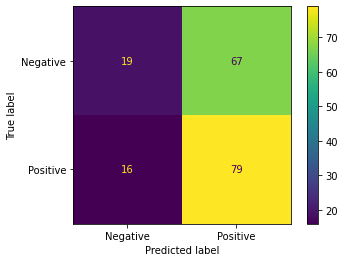

In [ ]:
metrics.plot_confusion_matrix(lr_classifier,X_test,df_A_test['class'])

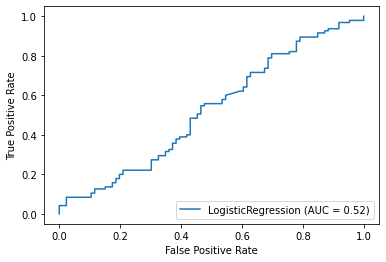

In [ ]:
metrics.plot_roc_curve(lr_classifier, X_test, df_A_test['class'])

### **Decision Trees**

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train,df_A_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree.score(X_test,df_A_test['class'])

0.49171270718232046

In [ ]:
accuracy_scores = cross_val_score(tree, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.51603499 0.58309038 0.54385965], mean = 0.5476616711847647, stdev = 0.02750694434820958


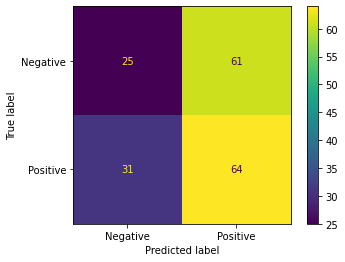

In [ ]:
metrics.plot_confusion_matrix(tree,X_test,df_A_test['class'])

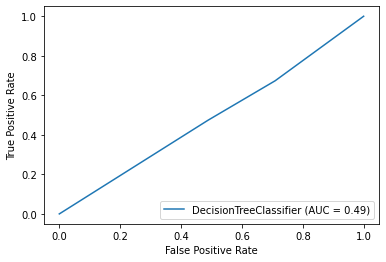

In [ ]:
metrics.plot_roc_curve(tree, X_test, df_A_test['class'])

# **Task - everything**

In [ ]:
df_B_train = shared_task_train
df_B_train = df_B_train.dropna()
df_B_train = pd.merge(df_B_train,crowd_train,on='user_id')
df_B_train = pd.merge(df_B_train,df_class, on = 'label')

In [ ]:
df_B_test = shared_task_test
df_B_test = df_B_test.dropna()
df_B_test = pd.merge(df_B_test,crowd_test,on='user_id')
df_B_test['label'] = df_B_test['raw_label']
df_B_test = pd.merge(df_B_test,df_class, on = 'label')

In [ ]:
x_b = convert_lines_to_feature_strings(df_B_train['post_body'],stopwords)

In [ ]:
X_train_b, training_vectorizer_b = convert_text_into_features(x_b,stopwords)

In [ ]:
X_test_b =  convert_lines_to_feature_strings(df_B_test['post_body'],stopwords)
X_test_b_features = training_vectorizer_b.transform(X_test_b)

### **Logistic Regression**

In [ ]:
lr_classifier_b = LogisticRegression(solver='liblinear')
lr_classifier_b.fit(X_train_b, df_B_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer_b,lr_classifier_b,20)

	-1.2712	itz_salust     		1.3301	post_deet      
	-1.2429	m_run          		1.2541	anoth_dimens   
	-1.1385	messag_soccerstud2691		1.1987	hear_voic      
	-1.1233	older_cousin   		1.1841	friend_code    
	-1.1007	board_school   		1.1656	thi_pictur     
	-1.0913	agent_phantom  		1.1321	asperg_        
	-1.0908	s_possibl      		1.1024	hear_loss      
	-1.0899	custom_game    		1.0838	post_psn       
	-1.0682	guy_           		1.0751	tri_play       
	-1.0597	san_diego      		1.0661	psn_bow        
	-1.0573	grad_school    		1.0349	solv_thi       
	-1.0544	bike_shop      		1.0330	m_17           
	-1.0358	front_page     		1.0077	declar_war     
	-1.0188	m_find         		0.9779	autist_spectrum
	-1.0090	close_friend   		0.9774	mani_year      
	-0.9955	rock_climb     		0.9763	m_schizophren  
	-0.9933	hey_fittit     		0.9641	start_keto     
	-0.9608	reddit_alien   		0.9563	thi_suck       
	-0.9605	shit_          		0.9562	hear_difficulti
	-0.9504	i_wa           		0.9542	s_syndrom      


In [ ]:
lr_classifier_b.score(X_test_b_features,df_B_test['class'])

0.547289033836119

In [ ]:
x_features_b = vstack([X_train_b,X_test_b_features])
data_B = pd.concat([df_B_train,df_B_test],axis=0)

In [ ]:
accuracy_scores_b = cross_val_score(lr_classifier_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

accuracy scores = [0.54875157 0.53536058 0.54199219], mean = 0.5420347790109035, stdev = 0.005466931314454443


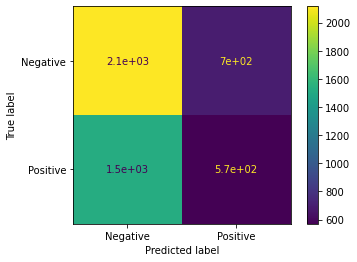

In [ ]:
metrics.plot_confusion_matrix(lr_classifier_b,X_test_b_features,df_B_test['class'])

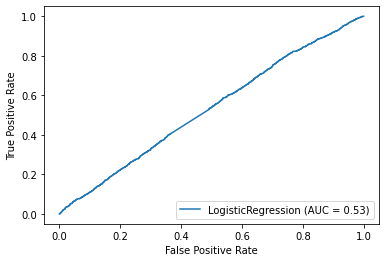

In [ ]:
metrics.plot_roc_curve(lr_classifier_b, X_test_b_features,df_B_test['class'])

### **Decision Trees**

In [ ]:
tree_b = DecisionTreeClassifier(criterion='entropy')
tree_b.fit(X_train_b, df_B_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_b.score(X_test_b_features,df_B_test['class'])

0.5356706074194864

In [ ]:
accuracy_scores = cross_val_score(tree_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

accuracy scores = [0.54875157 0.53536058 0.54199219], mean = 0.5420347790109035, stdev = 0.005466931314454443


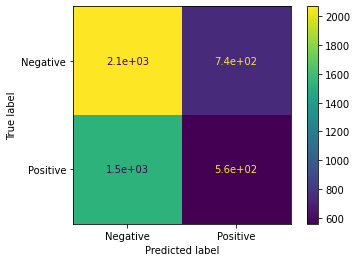

In [ ]:
metrics.plot_confusion_matrix(tree_b,X_test_b_features,df_B_test['class'])

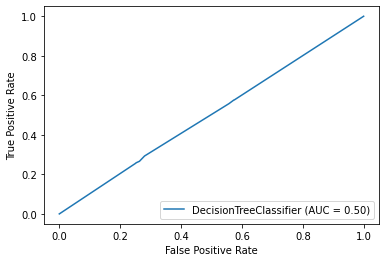

In [ ]:
metrics.plot_roc_curve(tree_b, X_test_b_features,df_B_test['class'])